<a href="https://colab.research.google.com/github/jason0419/RLStudyNotes/blob/main/Racetrack_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [ ]:
import numpy as np
import copy
import random

# modules for matplotlib and animations
import matplotlib.colors as mlc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
from IPython import display

import time

# Map data

In [ ]:
# Race Map from Sutton and Barto Figure 5.6: 
big_map  = ['WWWWWWWWWWWWWWWWWW',
              'WWWWooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWooooooooooooooo+',
              'Woooooooooooooooo+',
              'Woooooooooooooooo+',
              'WooooooooooWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWW------WWWWWWWW']

# Tiny course for debug
tiny_map  = ['WWWWWW',
               'Woooo+',
               'Woooo+',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'W--WWW',]

# Defined Environment

In [ ]:
class Map():

  def __init__(self, data):
    self.data, self.starting_positions, self.ending_positions, self.valid_positions, self.invalid_positions = self.create_map_from_string(data)
  
  # functions to convert map from text format to np.array format
  def map_character(self, character):
    if character == "W":
      return 0
    elif character == "o":
      return 1
    elif character == "-":
      return 2
    elif character == "+":
      return 3

  def create_map_from_string(self, _data):
    data = [[self.map_character(character) for character in line] for line in _data]
    data = [data[i] for i in np.arange(len(data)-1, -1, -1)]
    data = np.array(data)

    # list of starting, ending, valid and invalid positions
    starting_positions = np.argwhere(data == 2)
    ending_positions = np.argwhere(data == 3)
    valid_positions = np.argwhere(data > 0)
    invalid_positions = np.argwhere(data == 0)  

    return data, starting_positions, ending_positions, valid_positions, invalid_positions

In [ ]:
class Visualizer():
  
  def __init__(self, environment, dpi=50):
    # create map
    self.environment = environment
    self.map = environment.map
    self.position = environment.position

    map = copy.deepcopy(self.map.data)
    position = self.position
    map[position[0]][position[1]] = 4

    # plot map
    num_row = len(map)
    num_col = len(map[0])
    self.fig = plt.figure(figsize=(8, 8), dpi=dpi)
    self.ax = plt.axes(xlim=(0, num_col-1), ylim=(0, num_row-1))
    levels = [0, 1, 2, 3, 4, 5]
    colors = ['black', 'white', 'yellow', 'green', 'red']
    self.cmap, self.norm = mlc.from_levels_and_colors(levels, colors)

    # Minor ticks
    self.ax.set_xticks(np.arange(-.5, num_col, 1), minor=True)
    self.ax.set_yticks(np.arange(-.5, num_row, 1), minor=True)

    # Gridlines based on minor ticks
    self.ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

    # Remove minor ticks
    self.ax.tick_params(which='minor', bottom=False, left=False)
    self.im = plt.imshow(map, cmap=self.cmap, norm=self.norm, interpolation='none')    

  def show_current(self):
    im = self.im
    fig = self.fig
    map = copy.deepcopy(self.map.data)
    position = self.environment.position
    map[position[0]][position[1]] = 4

    im.set_data(map)
    # im = plt.imshow(map, cmap=cmap, norm=norm, interpolation='none')
    return fig

  def show_trajectory_static(self):
    im = self.im
    fig = self.fig
    map = copy.deepcopy(self.map.data)

    for position in self.environment.statePosition_trajectory:
      map[position[0]][position[1]] = 4

    im.set_data(map)
    # im = plt.imshow(map, cmap=cmap, norm=norm, interpolation='none')
    return fig

  def show_trajectory_animated(self):
    im = self.im
    fig = self.fig
    map = copy.deepcopy(self.map.data)
    
    # initialization function: plot the background of each frame
    def init():
      position = self.environment.statePosition_trajectory[0]
      map_with_car = copy.deepcopy(map)
      map_with_car[position[0]][position[1]] = 4
      im.set_data(map_with_car)
      return [im]

    # animation function.  This is called sequentially
    def animate(i):
      position = self.environment.statePosition_trajectory[i]
      map_with_car = copy.deepcopy(map)
      map_with_car[position[0]][position[1]] = 4
      im.set_data(map_with_car)
      return [im]

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=len(self.environment.statePosition_trajectory), interval=100, blit=True)

    return anim

In [ ]:
class Environment():
  def __init__(self, map_data, max_velocity=4, min_velocity=1, noise=0.0):
    self.map = Map(map_data)
    self.max_velocity = max_velocity
    self.min_velocity = min_velocity
    self.valid_velocities = tuple([np.array([vel_x, vel_y]) for vel_x in range(self.min_velocity, self.max_velocity+1) for vel_y in range(self.min_velocity, self.max_velocity+1)])
    self.noise = noise
    self.generate_action_space()
    self.is_terminal = False
    self.statePosition_trajectory = []
    self.stateVelocity_trajectory = []
    self.action_trajectory = []
    self.actionIndex_trajectory = []
    self.reward_trajectory = []
    self.step = 0
    self.random_start()
    self.visualizer = Visualizer(self)

  def reset(self):
    self.is_terminal = False
    self.statePosition_trajectory = []
    self.stateVelocity_trajectory = []
    self.action_trajectory = []
    self.actionIndex_trajectory = []
    self.reward_trajectory = []
    self.step = 0
    self.random_start()

  def update_state_trajectory(self):
    self.statePosition_trajectory.append(self.position.copy())
    self.stateVelocity_trajectory.append(self.velocity.copy())

  def random_start(self):
    # print("RANDOM START")
    self.is_random_start = True
    self.position = random.choice(self.map.starting_positions).copy()
    self.velocity = np.array([0,0])
    self.update_state_trajectory()

  def get_state(self):

    return (self.position[0], self.position[1], self.velocity[0], self.velocity[1])

  def is_action_valid(self, state, action):
    velocity = np.array([state[2], state[3]])
    new_velocity = velocity + np.array(action)
    check_zero = ((new_velocity[0] >= 0) & (new_velocity[1] >= 0)) 
    check_min = ((new_velocity[0] >= self.min_velocity) | (new_velocity[1] >= self.min_velocity))
    check_max = ((new_velocity[0] <= self.max_velocity) & (new_velocity[1] <= self.max_velocity)) 
    return (check_zero & check_min & check_max)

  def is_out_of_bounds(self):
    position = self.position.copy() * 1.0 
    for step in range(self.max_velocity):
      x = int(np.ceil(position[0]))
      y = int(np.ceil(position[1]))
      if (self.map.data[x][y] == 0):
        return True
      position += self.velocity/self.max_velocity
    return False

  def is_finished(self):
    position = self.position.copy() * 1.0
    for step in range(self.max_velocity):
      x = int(np.ceil(position[0]))
      y = int(np.ceil(position[1]))
      try:
        # print([x,y], self.map.data[x][y], self.map.data[x][y] == 3)
        if (self.map.data[x][y] == 3):
          self.position = np.array([x,y])
          return True
      except IndexError:
        return False
      position += self.velocity/self.max_velocity
    return False

  def show_debug_message(self):
    print("Step=",self.step)
    print("Old Position=", self.statePosition_trajectory[-2], " Old Velocity=", self.stateVelocity_trajectory[-2])
    print("Action=", self.action_trajectory[-1], " New Velocity=", self.stateVelocity_trajectory[-1], " New Position=", self.statePosition_trajectory[-1])
    print("")
    print("StatePosition_Trajectory=",self.statePosition_trajectory)
    print("StateVelocity_Trajectory=",self.stateVelocity_trajectory)
    print("Action_Trajectory=",self.action_trajectory)
    print("ActionIndex_Trajectory=",self.action_trajectory)
    print("Reward_Trajectory=",self.reward_trajectory)
    print("Random start", self.is_random_start)
    print("Finished", self.is_terminal)
    print("################")

  def take_action(self, action_index):
    self.step += 1
    self.actionIndex_trajectory.append(action_index)
    state = (self.position[0], self.position[1], self.velocity[0], self.velocity[1])
    action = self.action_space[state][action_index]
    self.action_trajectory.append(np.array(action))
    self.reward_trajectory.append(-1)
    if (np.random.rand() > self.noise):
      self.velocity += np.array(action)

    if(self.is_finished()):
      self.is_terminal = True
      self.update_state_trajectory()
      return True
    elif(self.is_out_of_bounds()):
      # print("OUT OF BOUNDS")
      self.random_start()
      return False
    else:
      self.is_random_start = False
      self.position += self.velocity
      self.update_state_trajectory()
      return False

  def generate_action_space(self):
    # generate action space
    self.action_space = dict()

    for pos_y in range(len(self.map.data)):
      for pos_x in range(len(self.map.data[0])):
        for vel_y in range(self.max_velocity+1):
          for vel_x in range(self.max_velocity+1):
            state = (pos_y, pos_x, vel_y, vel_x)
            self.action_space[state]=[]

    for pos_y in range(len(self.map.data)):
      for pos_x in range(len(self.map.data[0])):
        for vel_y in range(self.max_velocity+1):
          for vel_x in range(self.max_velocity+1):
            for act_y in range(-1,2):
              for act_x in range(-1,2):
                action = np.array([act_y, act_x])
                state = (pos_y, pos_x, vel_y, vel_x)            
                if(self.is_action_valid(state, action)):
                  self.action_space[state].append(np.array([act_y, act_x]))


# Monte Carlo On-Policy Every-Visit Control

In [ ]:
class Monte_Carlo_OnPolicy_EveryVisit_Control():
  def __init__(self, environment, epsilon, gamma):
    self.environment = environment
    self.epsilon = epsilon
    self.gamma = gamma
    self.initialize_state_action_value()
    self.initialize_state_action_numberVisit()

  def initialize_state_action_value(self, initial_value=0):
    self.state_action_value = self.environment.action_space.copy()
    for state in self.state_action_value:
      number_of_available_actions = len(self.state_action_value[state])
      self.state_action_value[state] = np.ones(number_of_available_actions) * initial_value

  def initialize_state_action_numberVisit(self):
    self.state_action_numberVisit = self.environment.action_space.copy()
    for state in self.state_action_numberVisit:
      number_of_available_actions = len(self.state_action_numberVisit[state])
      self.state_action_numberVisit[state] = np.zeros(number_of_available_actions)

  def sample_episode(self):
    self.environment.reset()
    while(self.environment.is_terminal == False):
      state = self.environment.get_state()
      available_actions = self.environment.action_space[state]
      num_available_actions = len(available_actions)
      index_of_greedy_action = np.argmax(self.state_action_value[state])
      prob = np.array([self.epsilon / num_available_actions for action in available_actions])
      prob[index_of_greedy_action] += 1-self.epsilon
      selected_action_index = np.random.choice(num_available_actions, p=prob)
      self.environment.take_action(selected_action_index)
    return self.environment.step
  
  def run(self, number_episodes):
    average_step = 0
    for i in range(number_episodes):
      average_step += self.sample_episode()/number_episodes
      self.update_state_action_value()
    return average_step

  def update_state_action_value(self):
    g = 0
    for i in range(self.environment.step):

      g = g*self.gamma + environment.reward_trajectory[-i-1]

      position = self.environment.statePosition_trajectory[-i-2]
      velocity = self.environment.stateVelocity_trajectory[-i-2]
      state = (position[0], position[1], velocity[0], velocity[1])
      action_index = self.environment.actionIndex_trajectory[-i-1]

      self.state_action_numberVisit[state][action_index] += 1
      numberVisit = self.state_action_numberVisit[state][action_index] 
      self.state_action_value[state][action_index] = (numberVisit - 1) / numberVisit * self.state_action_value[state][action_index] + 1 / numberVisit * g



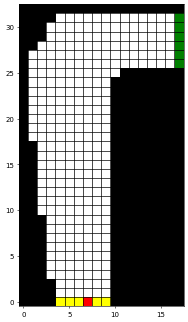

In [ ]:
# create environment
environment = Environment(big_map)

In [ ]:
%%time
# initialize control
control1 = Monte_Carlo_OnPolicy_EveryVisit_Control(environment, epsilon=0.1, gamma=0.9)
control1.initialize_state_action_value(-40)

# set initial policy to [0,0]
for state in control1.state_action_value:
  try:
    index = np.argwhere((control1.environment.action_space[state] == np.array([0,0])).prod(axis=1) == 1)
    control1.state_action_value[state][index] += 1
  except IndexError:
    pass

# run 100,000 episodes, and evaluate (100 episodes) every 10,000 episodes
for i in range(10):
  average_step = control1.run(10000)
  print("Episode ", (i+1)*10000, " Average Steps = ", average_step)
  evaluation = 0
  for j in range(100):
    control1.sample_episode()
    evaluation += control1.environment.step/100

  print("Evaluation = ", evaluation)
  print("")

Episode  10000  Average Steps =  29.753900000000854
Evaluation =  23.02

Episode  20000  Average Steps =  18.916900000001004
Evaluation =  18.060000000000006

Episode  30000  Average Steps =  17.517300000001157
Evaluation =  16.22

Episode  40000  Average Steps =  16.427200000001424
Evaluation =  16.530000000000005

Episode  50000  Average Steps =  16.004900000001346
Evaluation =  16.099999999999994

Episode  60000  Average Steps =  15.814400000001324
Evaluation =  15.570000000000002

Episode  70000  Average Steps =  15.682100000001313
Evaluation =  15.269999999999992

Episode  80000  Average Steps =  15.643000000001367
Evaluation =  15.840000000000005

Episode  90000  Average Steps =  15.564100000001424
Evaluation =  15.549999999999999

Episode  100000  Average Steps =  15.292400000001455
Evaluation =  15.570000000000002

CPU times: user 3min 52s, sys: 1.79 s, total: 3min 54s
Wall time: 4min 3s


# Monte Carlo Off-Policy Control

In [ ]:
class Monte_Carlo_OffPolicy_Control():
  def __init__(self, environment, epsilon, gamma):
    self.environment = environment
    self.epsilon = epsilon
    self.gamma = gamma
    self.initialize_state_action_value()
    self.target_policy = dict()
    for state in self.environment.action_space:
      self.target_policy[state] = 0
    self.cumsum_weight = self.environment.action_space.copy()
    for state in self.cumsum_weight:
      number_of_available_actions = len(self.cumsum_weight[state])
      self.cumsum_weight[state] = np.zeros(number_of_available_actions)

  def initialize_state_action_value(self, initial_value=0):
    self.state_action_value = self.environment.action_space.copy()
    for state in self.state_action_value:
      number_of_available_actions = len(self.state_action_value[state])
      self.state_action_value[state] = np.ones(number_of_available_actions) * initial_value

  def sample_episode(self):
    self.environment.reset()
    while(self.environment.is_terminal == False):
      state = self.environment.get_state()
      available_actions = self.environment.action_space[state]
      num_available_actions = len(available_actions)
      index_of_greedy_action = np.argmax(self.state_action_value[state])
      prob = np.array([self.epsilon / num_available_actions for action in available_actions])
      prob[index_of_greedy_action] += 1-self.epsilon
      selected_action_index = np.random.choice(num_available_actions, p=prob)
      self.environment.take_action(selected_action_index)
    return self.environment.step
  
  def evaluate_target_policy(self, max_step=1000):
    self.environment.reset()
    while(self.environment.is_terminal == False):
      if(self.environment.step>max_step):
        return None
      state = self.environment.get_state()
      self.environment.take_action(self.target_policy[state])
    return self.environment.step

  def run(self, number_episodes):
    average_step = 0
    for i in range(number_episodes):
      average_step += self.sample_episode()/number_episodes
      self.update_state_action_value()
    return average_step

  def update_target_policy(self):
    for state in self.state_action_value:
      self.target_policy[state] = np.argmax(self.state_action_value[state])

  def update_state_action_value(self):
    g = 0
    w = 1
    for i in range(self.environment.step):

      g = g*self.gamma + self.environment.reward_trajectory[-i-1]

      position = self.environment.statePosition_trajectory[-i-2]
      velocity = self.environment.stateVelocity_trajectory[-i-2]
      state = (position[0], position[1], velocity[0], velocity[1])
      action_index = self.environment.actionIndex_trajectory[-i-1]

      self.cumsum_weight[state][action_index] += w
      c = self.cumsum_weight[state][action_index] 
      self.state_action_value[state][action_index] = (c - w) / c * self.state_action_value[state][action_index] + w / c * g
      self.target_policy[state] = np.argmax(self.state_action_value[state])

      n = len(self.environment.action_space[state]) # number_of_available_actions

      # print(self.target_policy[state], ",", action_index, ",", w, ",", c)
      if (self.target_policy[state] == action_index):
        w = w * 1 / (1 - (n-1)/n * self.epsilon)
      else:
        break

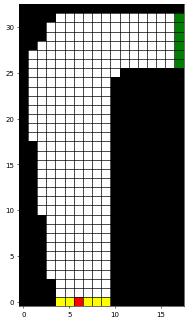

In [ ]:
# create environment
environment = Environment(big_map)

In [ ]:
%%time
# initialize control
control2 = Monte_Carlo_OffPolicy_Control(environment, epsilon=0.1, gamma=0.9)
control2.initialize_state_action_value(-40)

# set initial policy to [0,0]
for state in control2.state_action_value:
  try:
    index = np.argwhere((control2.environment.action_space[state] == np.array([0,0])).prod(axis=1) == 1)
    control2.state_action_value[state][index] += 1
  except IndexError:
    pass

control2.update_target_policy()

# run 100,000 episodes, and evaluate (100 episodes) every 10,000 episodes
for i in range(10):
  average_step = control2.run(10000)
  print("Episode ", (i+1)*10000, " Average Steps = ", average_step)

  evaluation = 0
  for j in range(100):
    control2.evaluate_target_policy()
    evaluation += control1.environment.step/100

  print("Evaluation = ", evaluation)
  print("")

Episode  10000  Average Steps =  27.418500000000318
Evaluation =  17.000000000000004

Episode  20000  Average Steps =  19.490800000000977
Evaluation =  17.000000000000004

Episode  30000  Average Steps =  18.73930000000119
Evaluation =  17.000000000000004

Episode  40000  Average Steps =  17.163800000001473
Evaluation =  17.000000000000004

Episode  50000  Average Steps =  16.513700000001187
Evaluation =  17.000000000000004

Episode  60000  Average Steps =  15.838800000001045
Evaluation =  17.000000000000004

Episode  70000  Average Steps =  15.38820000000073
Evaluation =  17.000000000000004

Episode  80000  Average Steps =  15.166700000000809
Evaluation =  17.000000000000004

Episode  90000  Average Steps =  15.05970000000074
Evaluation =  17.000000000000004

Episode  100000  Average Steps =  15.024200000000597
Evaluation =  17.000000000000004

CPU times: user 3min 42s, sys: 1.81 s, total: 3min 44s
Wall time: 3min 44s


# Comparison

In [35]:
%%time
# Evaluation of Monte Carlo On-Policy Every-Visit Control
from scipy import stats as st
step = []
for i in range(1000):
  control1.sample_episode()
  step.append(control1.environment.step)

step = np.array(step)
print(step.min(), st.mode(step)[0][0], step.mean(), step.max())

11 12 15.438 47
CPU times: user 2.21 s, sys: 18.1 ms, total: 2.23 s
Wall time: 3.66 s


In [30]:
control1.sample_episode()
print(control1.environment.step)
control1.environment.visualizer.show_trajectory_animated()

23


In [31]:
control1.sample_episode()
print(control1.environment.step)
control1.environment.visualizer.show_trajectory_animated()

12


In [36]:
%%time
# Evaluation of Monte Carlo On-Policy Every-Visit Control
from scipy import stats as st
step = []
for i in range(1000):
  control2.evaluate_target_policy()
  step.append(control2.environment.step)

step = np.array(step)
print(step.min(), st.mode(step)[0][0], step.mean(), step.max())

11 11 11.593 14
CPU times: user 831 ms, sys: 2.97 ms, total: 834 ms
Wall time: 837 ms


In [56]:
control2.evaluate_target_policy()
print(control2.environment.step)
control2.environment.visualizer.show_trajectory_animated()

11


In [54]:
control2.evaluate_target_policy()
print(control2.environment.step)
control2.environment.visualizer.show_trajectory_animated()

13


In [53]:
control2.evaluate_target_policy()
print(control2.environment.step)
control2.environment.visualizer.show_trajectory_animated()

12


# Environment with Noise

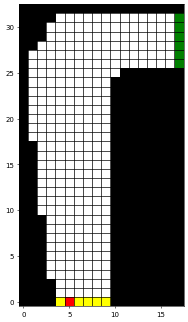

In [ ]:
# initialize environment
environment2 = Environment(big_map, noise=0.3)

In [ ]:
%%time
# initialize control
control3 = Monte_Carlo_OffPolicy_Control(environment2, epsilon=0.1, gamma=0.9)
control3.initialize_state_action_value(-40)

# set initial policy to [0,0]
for state in control3.state_action_value:
  try:
    index = np.argwhere((control3.environment.action_space[state] == np.array([0,0])).prod(axis=1) == 1)
    control3.state_action_value[state][index] += 1
  except IndexError:
    pass

control3.update_target_policy()

# run 100,000 episodes, and evaluate (100 episodes) every 10,000 episodes
for i in range(10):
  average_step = control3.run(10000)
  print("Episode ", (i+1)*10000, " Average Steps = ", average_step)

  evaluation = 0
  for j in range(100):
    control3.evaluate_target_policy()
    evaluation += control3.environment.step/100

  print("Evaluation = ", evaluation)
  print("")

Episode  10000  Average Steps =  45.17290000000074
Evaluation =  20.360000000000017

Episode  20000  Average Steps =  30.619999999999234
Evaluation =  19.480000000000008

Episode  30000  Average Steps =  28.845699999999297
Evaluation =  18.580000000000016

Episode  40000  Average Steps =  28.017599999999124
Evaluation =  19.330000000000002

Episode  50000  Average Steps =  27.266699999999158
Evaluation =  18.950000000000006

Episode  60000  Average Steps =  26.885599999999055
Evaluation =  19.519999999999992

Episode  70000  Average Steps =  26.74689999999918
Evaluation =  19.440000000000005

Episode  80000  Average Steps =  26.533399999999187
Evaluation =  19.54000000000001

Episode  90000  Average Steps =  26.08509999999915
Evaluation =  18.450000000000006

Episode  100000  Average Steps =  25.4578999999991
Evaluation =  18.080000000000005

CPU times: user 6min 3s, sys: 2.91 s, total: 6min 5s
Wall time: 6min 5s


In [ ]:
%%time
# Evaluation
from scipy import stats as st
step = []
for i in range(1000):
  control3.evaluate_target_policy()
  step.append(environment.step)

step = np.array(step)
print(step.min(), st.mode(step)[0][0], step.mean(), step.max())

11 11 11.0 11
CPU times: user 1.38 s, sys: 17.1 ms, total: 1.4 s
Wall time: 1.39 s


In [ ]:
environment2.visualizer.show_trajectory_animated()